# Load and work with shapefile data

In [1]:
import numpy as np
import shapefile

In [2]:
TRANSPORT_DIR = './data/VMTRANS2/'
sf = shapefile.Reader(TRANSPORT_DIR + 'TR_ROAD')
print(np.unique([s.shapeTypeName for s in sf.shapes()], return_counts=True))
print(', '.join([f[0] for f in sf.fields]))

(array(['POLYLINE'], dtype='<U8'), array([1167929]))
DeletionFlag, PFI, UFI, FTYPE_CODE, NFEAT_ID, EZI_RDNAME, EZIRDNMLBL, ROAD_NAME, ROAD_TYPE, RD_SUF, RDNAMEUSE, RD_NAME1, RD_TYPE1, RD_SUF1, RDNAMEUSE1, RD_NAME2, RD_TYPE2, RD_SUF2, RDNAMEUSE2, RD_NAME3, RD_TYPE3, RD_SUF3, RDNAMEUSE3, RD_NAME4, RD_TYPE4, RD_SUF4, RDNAMEUSE4, RD_NAME5, RD_TYPE5, RD_SUF5, RDNAMEUSE5, RD_NAME6, RD_TYPE6, RD_SUF6, RDNAMEUSE6, RD_NAME7, RD_TYPE7, RD_SUF7, RDNAMEUSE7, LEFT_LOC, RIGHT_LOC, CLASS_CODE, DIR_CODE, ROUTE_NO, STRUCTNAME, HT_LIMIT, RESTRICTN, PHYS_COND, CONST_TYPE, ROAD_SEAL, DIV_RD, RD_STATUS, VECACCESS, SEASCLSEDT, SEASOPENDT, LOAD_LIMIT, LDLMTASSDT, CONS_MAT, LENGTH_M, WIDTH_M, DECK_AREA, RESPAUTHCD, COORDAUTHC, URBAN, NRE_ROUTE, FROM_UFI, TO_UFI, FQID, CRDATE_PFI, SUPER_PFI, CRDATE_UFI


In [3]:
def all_srs():
  return sf.shapeRecords()

def get_attrs(srs, attr):
  return [sr.record[attr] for sr in srs]

def get_attr_vals(srs, attr):
  return np.unique(get_attrs(srs, attr), return_counts=True)

def matching_srs(srs, attr, val):
  return [sr for sr in srs if sr.record[attr] == val]

def get_geom(sr):
  return np.array(sr.shape.points)

def get_geoms(srs):
  return [get_geom(sr) for sr in srs]

def geom_bb(g):
  return np.array([np.min(g, axis=0), np.max(g, axis=0)])

def clipped_srs(srs, bb):
  geom_bbs = np.stack([geom_bb(get_geom(sr)) for sr in srs])
  bb_deltas = geom_bbs - bb
  in_bb_bl = np.min(bb_deltas[:,0,:] >= 0, axis=1)
  in_bb_tr = np.min(bb_deltas[:,1,:] < 0, axis=1)
  in_bb = np.logical_and(in_bb_bl, in_bb_tr)  
  return [srs[i] for i in np.argwhere(in_bb).flatten()]

In [4]:
asrs = all_srs()

In [5]:
bairnsdale_outskirts_bb = np.array([[2720000, 2400000], [2740000, 2415000]])
bairnsdale_centre_bb = np.array([[2727500, 2402000], [2732500, 2405750]])
bairnsdale_roundabouts_bb = np.array([[2728000, 2403500], [2731000, 2405750]])
bairnsdale_tight_bb = np.array([[2728000, 2403500], [2729000, 2404200]])

# Visualise geometries and attributes

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random

cat_colors = mpl.cm.tab10_r

def plot_srs(ax, srs, limit=4096, decay=2, lw=1):
  class_limit = limit
  for i in range(9):
    class_limit = class_limit // decay
    msrs = matching_srs(srs, 'CLASS_CODE', i)
    plot_geoms(ax, get_geoms(msrs), limit=class_limit, c=cat_colors(i), lw=lw)

def plot_geoms(ax, gs, limit=1024, c='tab:cyan', z=0, lw=1):
  gs_lim = gs if len(gs) < limit else random.sample(gs, limit)
  for g in gs_lim:
    ax.plot(g[:,0], g[:,1], color=c, zorder=z, lw=lw)

def init_fig(width=12, height=9):
  fig, ax = plt.subplots()
  fig.set_figwidth(width)
  fig.set_figheight(height)
  fig.set_facecolor('w')
  return fig, ax

def fig_srs(srs, title='', limit=4096, decay=2):
  fig, ax = init_fig()
  plot_srs(ax, srs, limit, decay)
  plt.axis('off')
  plt.title(title)
  plt.show()

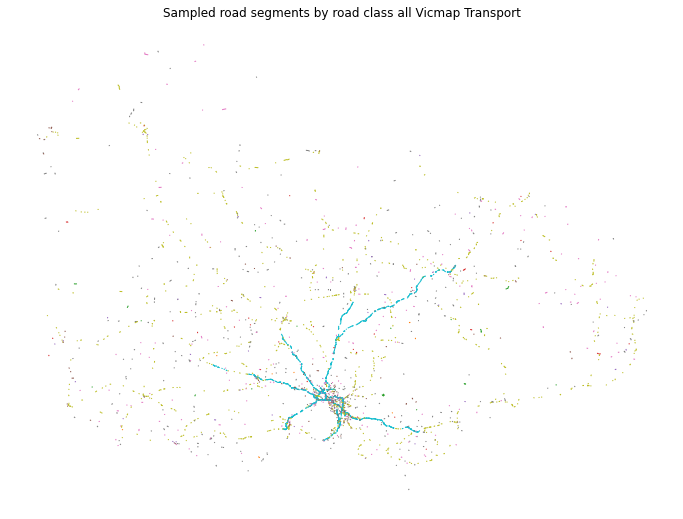

In [7]:
fig_srs(asrs, 'Sampled road segments by road class all Vicmap Transport')

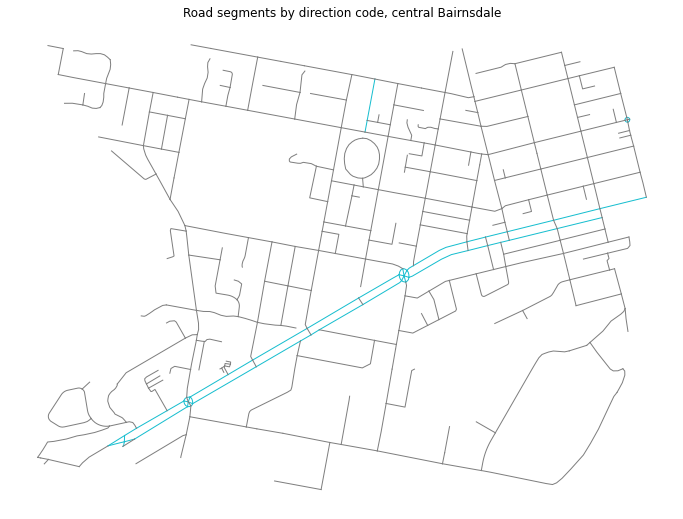

In [8]:
dir_vals = ['F', 'R', 'B']
tmp_srs = clipped_srs(asrs, bairnsdale_roundabouts_bb)
csrs_ow = [matching_srs(tmp_srs, 'DIR_CODE', v) for v in dir_vals]

fig, ax = init_fig()
for i, sr in enumerate(csrs_ow):
  plot_geoms(ax, get_geoms(sr), c=cat_colors(i))
plt.axis('off')
plt.title('Road segments by direction code, central Bairnsdale')
plt.show()

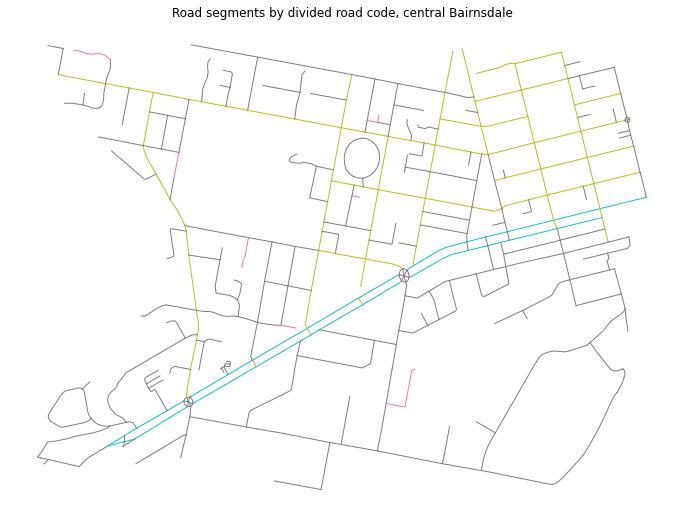

In [9]:
div_vals = ['DD', 'DS', 'ND', 'U']
tmp_srs = clipped_srs(asrs, bairnsdale_roundabouts_bb)
csrs_divs = [matching_srs(tmp_srs, 'DIV_RD', v) for v in div_vals]

fig, ax = init_fig()
for i, sr in enumerate(csrs_divs):
  plot_geoms(ax, get_geoms(sr), c=cat_colors(i))
plt.axis('off')
plt.title('Road segments by divided road code, central Bairnsdale')
plt.show()

# Build a graph

In [10]:
from scipy.spatial import KDTree

def terminal_points(gs):
  return np.concatenate([[g[0] for g in gs], [g[-1] for g in gs]])

def coincident_terminal_points(srs):
  tps = terminal_points(get_geoms(srs))
  coincident_ids = list(KDTree(tps).query_pairs(0.01))
  sorted_ids = np.array(sorted(coincident_ids))
  return tps, (sorted_ids[:,0], sorted_ids[:,1])

def canonical_map(pairs, num_ids):
  aggregate_js, first_instances = np.unique(pairs[1], return_index=True)
  aggregate_is = pairs[0][first_instances]
  cmap = np.arange(num_ids)
  cmap[aggregate_js] = aggregate_is
  return cmap

def edges_from_coincident(coincident_ids, num_ids):
  cmap = canonical_map(coincident_ids, num_ids)
  num_edges = num_ids // 2
  return np.stack((cmap[:num_edges], cmap[num_edges:])).T

In [11]:
import networkx as nx

def make_ugraph(srs):
  tps, coincident_ids = coincident_terminal_points(srs)
  geom_edges = edges_from_coincident(coincident_ids, tps.shape[0])
  G = nx.Graph()
  g_edges = list(zip(geom_edges[:,0], geom_edges[:,1]))
  G.add_edges_from(g_edges)
  nx.set_node_attributes(G, {n : tps[n, 0] for n in G.nodes()}, 'x')
  nx.set_node_attributes(G, {n : tps[n, 1] for n in G.nodes()}, 'y')
  nx.set_edge_attributes(G, {g_edges[i] : {'gid': i} for i in range(len(srs))})
  # todo dups
  return G, []

In [12]:
def make_digraph(srs):
  tps, coincident_ids = coincident_terminal_points(srs)
  geom_edges = edges_from_coincident(coincident_ids, tps.shape[0])
  dir_codes = np.array(get_attrs(srs, 'DIR_CODE'))
  # making directed edges
  f_codes = np.logical_or(dir_codes == 'F', dir_codes == 'B')
  r_codes = np.logical_or(dir_codes == 'R', dir_codes == 'B')
  f_gids = np.argwhere(f_codes).flatten()
  r_gids = np.argwhere(r_codes).flatten()
  f_edges = geom_edges[f_gids,:]
  r_edges = np.flip(geom_edges[r_gids,:], axis=1)
  uf_edges, f_edge_uids = np.unique(f_edges, return_index=True, axis=0)
  ur_edges, r_edge_uids = np.unique(r_edges, return_index=True, axis=0)
  u_edges = np.concatenate((uf_edges, ur_edges), axis=0)
  u_gids = np.concatenate((f_gids[f_edge_uids], r_gids[r_edge_uids]), axis=0)
  # making graph
  G = nx.DiGraph()
  tu_edges = list(zip(u_edges[:,0], u_edges[:,1]))
  G.add_edges_from(tu_edges)
  nx.set_node_attributes(G, {n : tps[n, 0] for n in G.nodes()}, 'x')
  nx.set_node_attributes(G, {n : tps[n, 1] for n in G.nodes()}, 'y')
  edge_gid_dict = {e : {'gid': u_gids[j]} for j, e in enumerate(tu_edges)}
  nx.set_edge_attributes(G, edge_gid_dict)
  return G

In [13]:
G = make_digraph(asrs)

# Visualise the graph

In [14]:
def draw_graph(G, w_labels=False):
  node_pos = {n : (G.nodes[n]['x'], G.nodes[n]['y']) for n in G.nodes}
  nx.draw(G, pos=node_pos, with_labels=w_labels,
          node_size=10, node_color='grey', edge_color='lightgrey')

def draw_path(G, path, color='tab:orange'):
  path_edges = list(zip(path[:-1], path[1:]))
  node_pos = {n : (G.nodes[n]['x'], G.nodes[n]['y']) for n in G.nodes}
  nx.draw(G, pos=node_pos, nodelist=path, edgelist=path_edges,
          node_size=20, width=3, node_color=color, edge_color=color)

def draw_path_geoms(ax, srs, G, path, color='tab:blue'):
  path_edges = list(zip(path[:-1], path[1:]))
  path_gids = [G.edges[pe]['gid'] for pe in path_edges]
  plot_geoms(ax, get_geoms([srs[gid] for gid in path_gids]), limit=2048, c=color, z=100, lw=3)

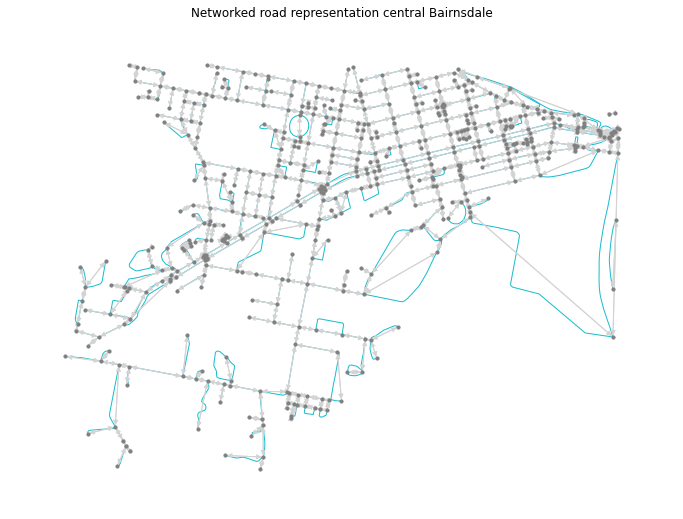

In [15]:
tmp_srs = clipped_srs(asrs, bairnsdale_centre_bb)

fig, ax = init_fig()
plot_geoms(ax, get_geoms(tmp_srs))
draw_graph(make_digraph(tmp_srs))
plt.title('Networked road representation central Bairnsdale')
plt.show()

# Post process graph with geometry attributes

In [16]:
def set_edge_attributes(G, srs, attribute_function, label):
  attr_list = attribute_function(G, srs)
  edge_attr = {e: {label: attr_list[i]} for i, e in enumerate(G.edges)}
  nx.set_edge_attributes(G, edge_attr)

In [17]:
def geom_length(g):
  deltas = g[1:] - g[:-1]
  seglens = np.hypot(deltas[:,0], deltas[:,1])
  return np.sum(seglens)

In [18]:
def geom_length_attr_fn(G, srs):
  gids = [G.edges[e]['gid'] for e in G.edges]
  return [geom_length(get_geom(srs[g])) for g in gids]

In [19]:
set_edge_attributes(G, asrs, geom_length_attr_fn, 'gl')

# Find paths through the graph

In [20]:
import random

nodes = list(G.nodes())
sn = random.choice(nodes) # 333 # 58088
en = random.choice(nodes) # 398 # 645752

In [21]:
path_hops = nx.shortest_path(G, sn, en)

In [22]:
path_geom_length = nx.shortest_path(G, sn, en, weight='gl')

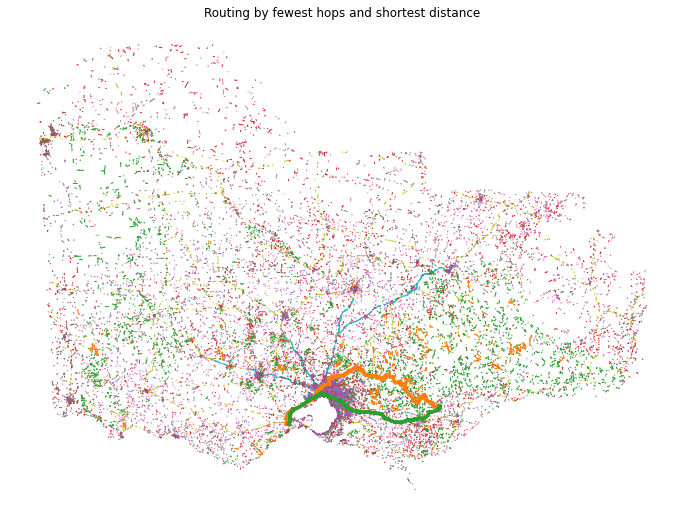

In [23]:
fig, ax = init_fig()
#draw_graph(G)
#draw_path(G, path_hops)
#draw_path(G, path_geom_length, color='tab:green')
draw_path_geoms(ax, asrs, G, path_hops, color='tab:orange')
draw_path_geoms(ax, asrs, G, path_geom_length, color='tab:green')
plot_srs(ax, asrs, decay=1)
plt.axis('off')
plt.title('Routing by fewest hops and shortest distance')
plt.show()

In [24]:
#nx.write_graphml(G, ('data/directed_with_distance_vic.gml'))

In [25]:
path_gl_edges = list(zip(path_geom_length[:-1], path_geom_length[1:]))
path_length = sum([G.edges[e]['gl'] for e in path_gl_edges])
round(path_length / 1000)

271